In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as st
import statsmodels.api as sm
from scipy.optimize import curve_fit
import scipy.signal as scs
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import pmdarima as pmd
from sklearn.preprocessing import StandardScaler



# Set the style of seaborn for better looking plots
sns.set()

In [78]:
ts = pd.read_csv('Reykjavik.csv')
ts

,time,weather_code (wmo code),temperature_2m_max (°C),temperature_2m_min (°C),temperature_2m_mean (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),apparent_temperature_mean (°C),sunrise (iso8601),sunset (iso8601),...,sunshine_duration (s),precipitation_sum (mm),rain_sum (mm),snowfall_sum (cm),precipitation_hours (h),wind_speed_10m_max (km/h),wind_gusts_10m_max (km/h),wind_direction_10m_dominant (°),shortwave_radiation_sum (MJ/m²),et0_fao_evapotranspiration (mm)
0,1/1/40,73,2.2,-1.7,0.3,-3.2,-6.8,-4.8,1940-01-01T11:18,1940-01-01T15:42,...,NaN,NaN,NaN,NaN,11,22.3,NaN,73,NaN,NaN
1,1/2/40,73,1.0,-0.4,0.3,-4.0,-5.9,-4.9,1940-01-02T11:17,1940-01-02T15:44,...,0.00,3.7,0.1,2.52,23,19.8,39.6,77,0.09,0.44
2,1/3/40,73,4.0,-0.4,1.9,1.2,-6.3,-3.1,1940-01-03T11:16,1940-01-03T15:46,...,0.00,5.0,1.2,2.66,16,30.0,54.0,102,0.10,0.27
3,1/4/40,53,5.4,1.5,2.5,1.5,-2.1,-1.3,1940-01-04T11:15,1940-01-04T15:48,...,828.68,2.1,2.1,0.00,12,21.1,27.7,150,0.20,0.02
4,1/5/40,55,6.5,4.6,5.6,1.8,0.2,1.2,1940-01-05T11:13,1940-01-05T15:50,...,0.00,5.5,5.5,0.00,11,29.9,52.9,148,0.16,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30950,9/26/24,3,5.1,-1.1,2.4,2.2,-4.2,-0.5,2024-09-26T07:23,2024-09-26T19:12,...,13904.13,0.0,0.0,0.00,0,9.4,20.2,318,5.18,0.60
30951,9/27/24,51,7.2,3.6,5.2,5.1,1.2,3.1,2024-09-27T07:26,2024-09-27T19:09,...,4209.56,1.1,1.1,0.00,11,11.8,21.2,92,4.15,0.56
30952,9/28/24,53,5.9,3.8,5.0,2.7,-0.1,1.4,2024-09-28T07:29,2024-09-28T19:05,...,0.00,4.2,4.2,0.00,16,16.8,31.7,103,1.70,0.45
30953,9/29/24,53,8.0,2.1,5.3,6.1,-1.6,2.1,2024-09-29T07:32,2024-09-29T19:02,...,7455.96,4.4,4.4,0.00,13,17.3,32.4,66,3.90,0.52


In [79]:
# Get data in dataframes and drop NaN values or fill them with 0
num_years = 84
temp_mean = ts['temperature_2m_mean (°C)'].iloc[:num_years*365].dropna()
precip = ts['precipitation_sum (mm)'].iloc[:num_years*365].dropna()
sun = ts['sunshine_duration (s)'].iloc[:num_years*365].dropna()

t = ts['time']
t_90s= [t[i][:-2]+str(1900+ int(t[i][-2:])) for i in range(365*60+14)]
t_20s= [t[i][:-2]+str(2000+ int(t[i][-2:])) for i in range(365*60+15,len(t))]
time = t_90s + t_20s
time = time[:num_years*365]
time = pd.to_datetime(time)

# Make data monthly to reduce computation time

In [99]:

monthly_temp_mean = temp_mean.rolling(window=30,step=30).mean().dropna()
monthly_precip_mean = precip.rolling(window=30,step=30).mean().dropna()
monthly_sun_mean = sun.rolling(window=30,step=30).mean().dropna()

monthly_temp_mean.index = range(monthly_temp_mean.size)
monthly_precip_mean.index = range(monthly_precip_mean.size)
monthly_sun_mean.index = range(monthly_sun_mean.size)

# make seasonal differencing
#monthly_temp_mean = monthly_temp_mean.diff(12).dropna()
#monthly_precip_mean = monthly_precip_mean.diff(12).dropna()
#monthly_sun_mean = monthly_sun_mean.diff(12).dropna()

# auto arima for temperature
model=pmd.auto_arima(monthly_temp_mean,start_p=1,start_q=1,m=12,seasonal=True,trace=True, )
model.summary()

monthly_temp_mean_train = monthly_temp_mean[0:81*12]
monthly_temp_mean_test = monthly_temp_mean[81*12:84*12]
monthly_precip_mean_train = monthly_precip_mean[0:81*12]
monthly_precip_mean_test = monthly_precip_mean[:3*12]
monthly_sun_mean_train = monthly_sun_mean[0:81*12]
monthly_sun_mean_test = monthly_sun_mean[:3*12]

# change train and test data to dataframes with indexes from 0 to 81*12 and 0 to 3*12
monthly_temp_mean_train.index = range(monthly_temp_mean_train.size)
monthly_temp_mean_test.index = range(monthly_temp_mean_test.size)
monthly_precip_mean_train.index = range(monthly_precip_mean_train.size)
monthly_precip_mean_test.index = range(monthly_precip_mean_test.size)
monthly_sun_mean_train.index = range(monthly_sun_mean_train.size)
monthly_sun_mean_test.index = range(monthly_sun_mean_test.size)


print("Monthly Temp Mean Shape" + str(monthly_temp_mean.shape))
print("Monthly Temp Mean Train Shape" + str(monthly_temp_mean_train.shape))
print("Monthly Temp Mean Test Shape" + str(monthly_temp_mean_test.shape))
print()
print("Monthly Precip Mean Shape" + str(monthly_precip_mean.shape))
print("Monthly Precip Mean Train Shape" + str(monthly_precip_mean_train.shape))
print("Monthly Precip Mean Test Shape" + str(monthly_precip_mean_test.shape))
print()
print("Monthly Sun Mean Shape" + str(monthly_sun_mean.shape))
print("Monthly Sun Mean Train Shape" + str(monthly_sun_mean_train.shape))
print("Monthly Sun Mean Test Shape" + str(monthly_sun_mean_test.shape))

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=4318.960, Time=3.29 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6200.859, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4519.509, Time=0.73 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5100.193, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=6675.473, Time=0.02 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=4884.528, Time=0.75 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=4519.704, Time=1.10 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=4319.228, Time=8.66 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=4335.871, Time=8.90 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=5083.897, Time=0.14 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=4789.281, Time=2.24 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=4379.483, Time=2.99 sec
 ARIMA(1,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=8.82 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=4330.275, Time=2.68 sec
 ARIMA(1,0,0)(1,0,1)[12]

Text(84.875, 0.5, 'Autocorrelation')

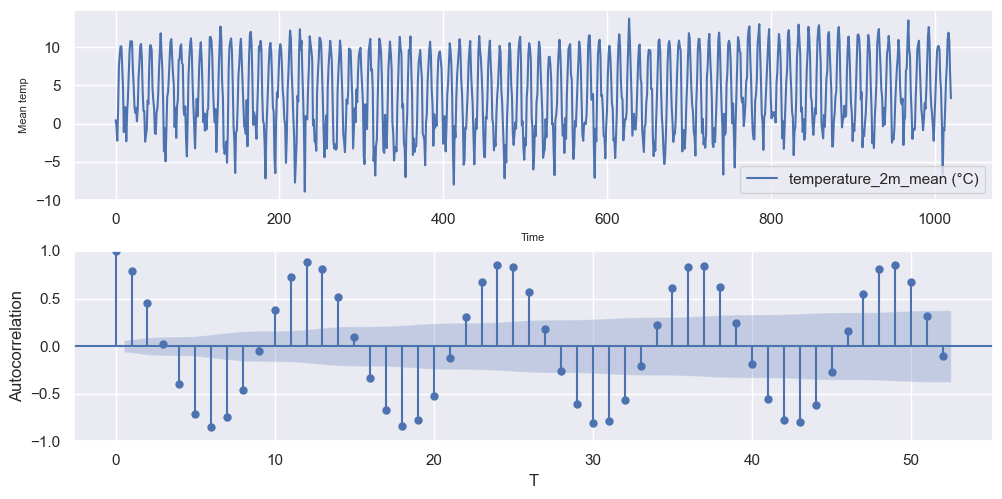

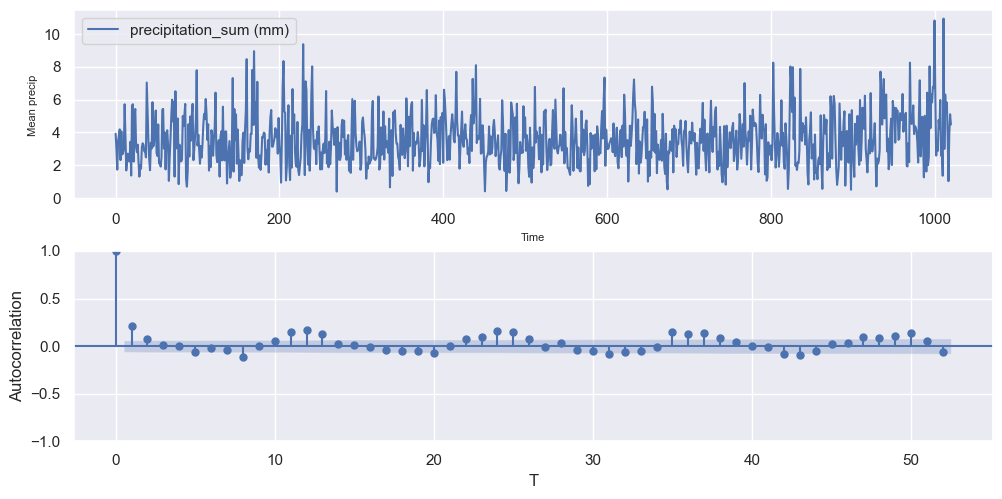

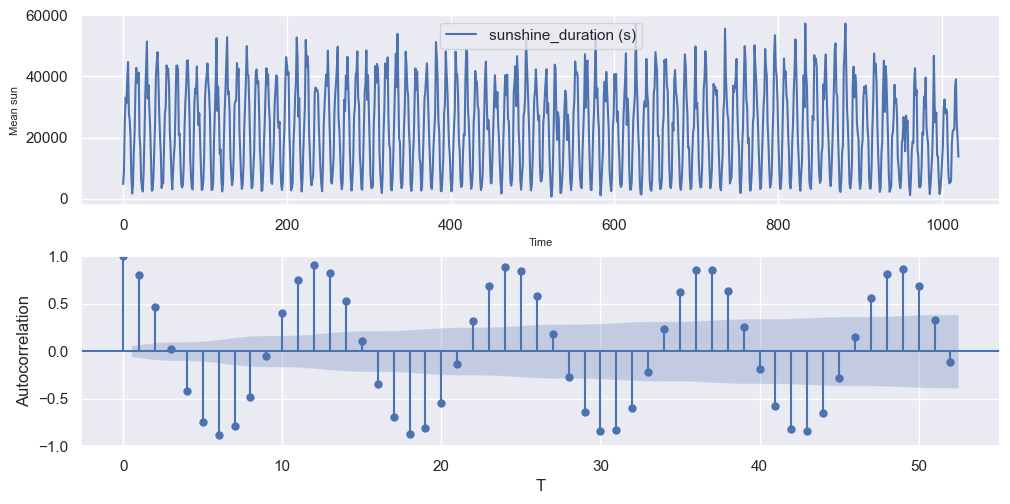

In [108]:
fig, axs=plt.subplots(2,figsize=(10,5))
fig.tight_layout()
monthly_temp_mean.plot(ax=axs[0],legend=True)
axs[0].set_ylabel('Mean temp',fontdict={'fontsize':8})
axs[0].set_xlabel('Time',fontdict={'fontsize':8})
plot_acf(monthly_temp_mean,ax=axs[1],title='', lags=52)
axs[1].set_xlabel("T")
axs[1].set_ylabel("Autocorrelation")

fig, axs=plt.subplots(2,figsize=(10,5))
fig.tight_layout()
monthly_precip_mean.plot(ax=axs[0],legend=True)
axs[0].set_ylabel('Mean precip',fontdict={'fontsize':8})
axs[0].set_xlabel('Time',fontdict={'fontsize':8})
plot_acf(monthly_precip_mean,ax=axs[1],title='', lags=52)
axs[1].set_xlabel("T")
axs[1].set_ylabel("Autocorrelation")

fig, axs=plt.subplots(2,figsize=(10,5))
fig.tight_layout()
monthly_sun_mean.plot(ax=axs[0],legend=True)
axs[0].set_ylabel('Mean sun',fontdict={'fontsize':8})
axs[0].set_xlabel('Time',fontdict={'fontsize':8})
plot_acf(monthly_sun_mean,ax=axs[1],title='', lags=52)
axs[1].set_xlabel("T")
axs[1].set_ylabel("Autocorrelation")


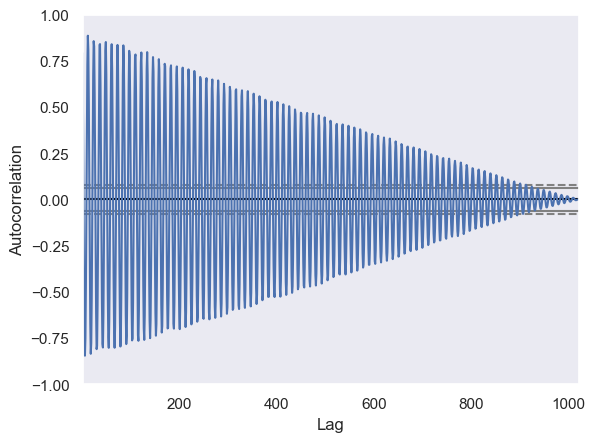

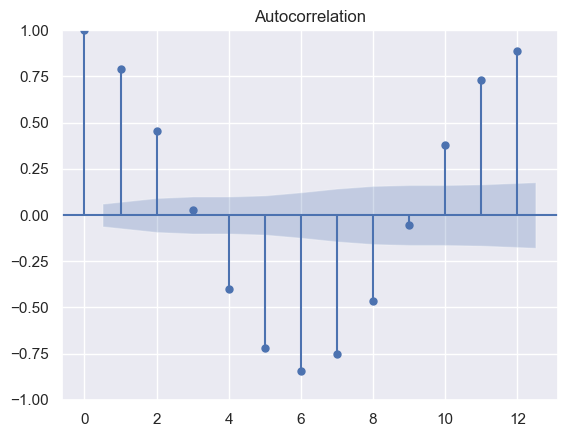

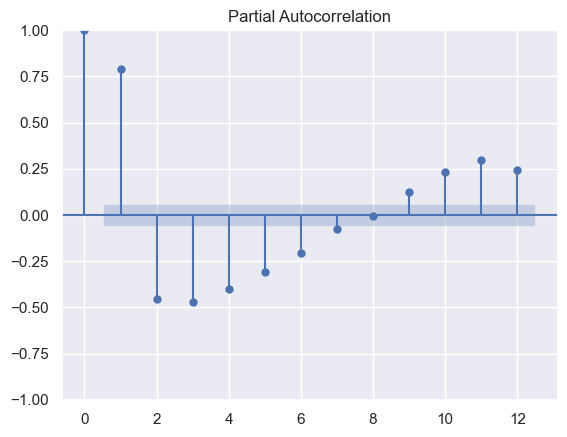

In [82]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
autocorrelation_plot(monthly_temp_mean)
plot_acf(monthly_temp_mean, lags=12)
plt.show()
plot_pacf(monthly_temp_mean, lags=12)
plt.show()

In [83]:
# HEGY test
# HEGY test
def hegy_test(y, max_lag):
    n = len(y)
    y = y - np.mean(y)
    y_lag = np.zeros((max_lag, n - max_lag))
    for i in range(max_lag):
        y_lag[i] = y[i:n - max_lag + i]
    y = y[max_lag:]
    y_lag = y_lag.T
    y_lag = sm.add_constant(y_lag)
    model = sm.OLS(y, y_lag).fit()
    return model.summary()

print(hegy_test(monthly_temp_mean, 12))

                               OLS Regression Results                               
Dep. Variable:     temperature_2m_mean (°C)   R-squared:                       0.875
Model:                                  OLS   Adj. R-squared:                  0.874
Method:                       Least Squares   F-statistic:                     581.8
Date:                      Sun, 08 Dec 2024   Prob (F-statistic):               0.00
Time:                              16:55:25   Log-Likelihood:                -2013.8
No. Observations:                      1009   AIC:                             4054.
Df Residuals:                           996   BIC:                             4117.
Df Model:                                12                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

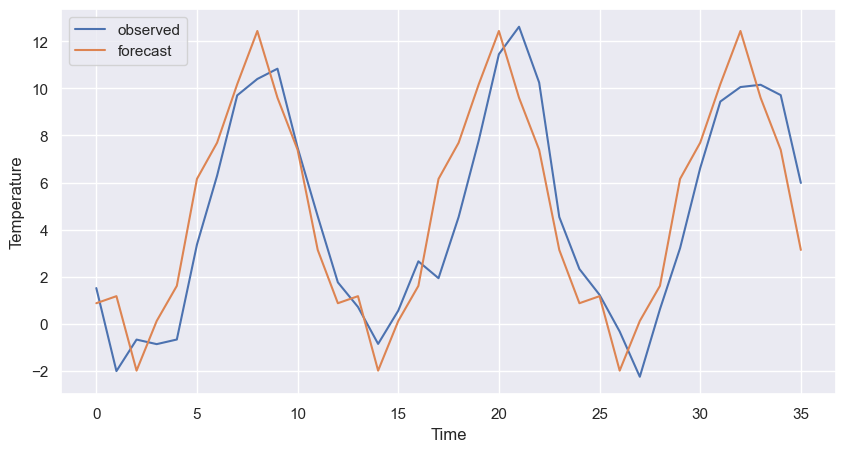

Mean squared error:3.745074608741576
Root Mean Squared Error:1.935219524690048
Mean absolute error:1.6466085256250729
Mean absolute percentage error:-6.534382688607629


In [157]:
# Forecasting with exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit the model
model = ExponentialSmoothing(monthly_temp_mean_train, seasonal='add', seasonal_periods=12)
results = model.fit()

# Get the forecast
forecast = results.forecast(steps=36)

# change index of forecast to be 0 to 3*12
forecast.index = range(forecast.size)

# Plot the forecast
plt.figure(figsize=(10,5))
plt.plot(monthly_temp_mean_test, label='observed')
plt.plot(forecast, label='forecast')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# check mean squared error between forecsat and test data
print("Mean squared error:" + str(mean_squared_error(monthly_temp_mean_test, forecast)))
print("Root Mean Squared Error:" + str(np.sqrt(mean_squared_error(monthly_temp_mean_test, forecast))))

# match index of forecast to monthly_temp_mean_test
forecast.index = monthly_temp_mean_test.index

print("Mean absolute error:" + str(np.mean(np.abs(monthly_temp_mean_test - forecast[:3*12]))))
print("Mean absolute percentage error:" + str(np.mean(np.abs(monthly_temp_mean_test - forecast)/monthly_temp_mean_test)*100))

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47449D+00    |proj g|=  2.12789D-01

At iterate    5    f=  2.40940D+00    |proj g|=  1.73960D-02

At iterate   10    f=  2.13757D+00    |proj g|=  5.44636D-02

At iterate   15    f=  2.12993D+00    |proj g|=  1.29970D-03

At iterate   20    f=  2.12829D+00    |proj g|=  4.37679D-02

At iterate   25    f=  2.12408D+00    |proj g|=  1.54934D-02

At iterate   30    f=  2.12363D+00    |proj g|=  1.98530D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

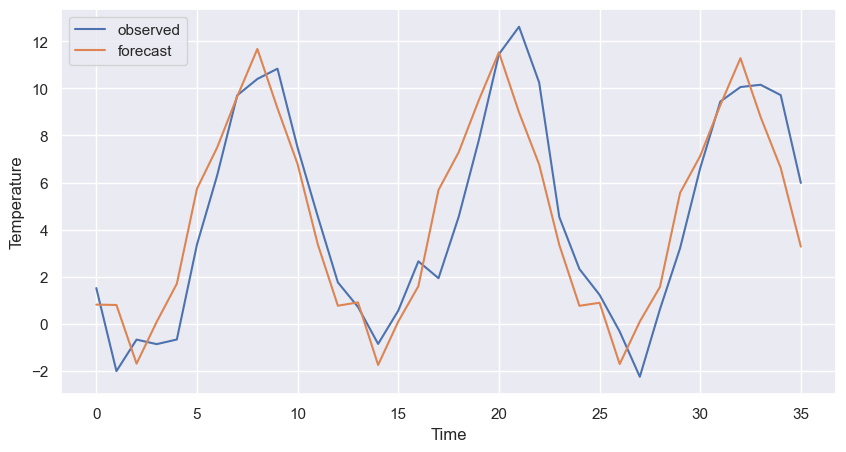

Mean squared error:3.3553998183823173
Root Mean Squared Error:1.8317750457909174
Mean absolute error:1.5137306676234454
Mean absolute percentage error:-4.62591665776578


In [158]:
# Forecast using SARIMA (requires stationarity)
# Fit the model
model = SARIMAX(monthly_temp_mean_train, order=(1, 0, 0), seasonal_order=(1, 0, 2, 12))
results = model.fit()

# Get the forecast add last value of monthly_temp_mean to first value of forecast
forecast = results.get_forecast(steps=36)
forecast_mean = forecast.predicted_mean

# change index of forecast to be 0 to 3*12
forecast_mean.index = range(forecast_mean.size)

# Plot the forecast
plt.figure(figsize=(10,5))
plt.plot(monthly_temp_mean_test, label='observed')
plt.plot(forecast_mean, label='forecast')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# check error metrics between forecsat and test data
print("Mean squared error:" + str(mean_squared_error(monthly_temp_mean_test, forecast_mean)))
print("Root Mean Squared Error:" + str(np.sqrt(mean_squared_error(monthly_temp_mean_test, forecast_mean[:3*12]))))

# match index of forecast to monthly_temp_mean_test
forecast_mean.index = monthly_temp_mean_test.index
#print(monthly_temp_mean_test)
#print(forecast_mean[:3*12])
print("Mean absolute error:" + str(np.mean(np.abs(monthly_temp_mean_test - forecast_mean[:3*12]))))
print("Mean absolute percentage error:" + str(np.mean(np.abs(monthly_temp_mean_test - forecast_mean[:3*12])/monthly_temp_mean_test)*100))

/home/athena/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.00811D+00    |proj g|=  9.40153D+00


 This problem is unconstrained.



At iterate    5    f=  2.14383D+00    |proj g|=  1.48770D-01

At iterate   10    f=  2.04922D+00    |proj g|=  3.15782D-03

At iterate   15    f=  2.04823D+00    |proj g|=  1.26003D-02

At iterate   20    f=  2.04483D+00    |proj g|=  3.76761D-03

At iterate   25    f=  2.04443D+00    |proj g|=  8.02546D-03

At iterate   30    f=  2.04430D+00    |proj g|=  1.99766D-03

At iterate   35    f=  2.04373D+00    |proj g|=  9.89811D-03

At iterate   40    f=  2.04347D+00    |proj g|=  7.54129D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43     50      1     0     0   6.669D-06   2.043D+00
  F =   2.04347208693

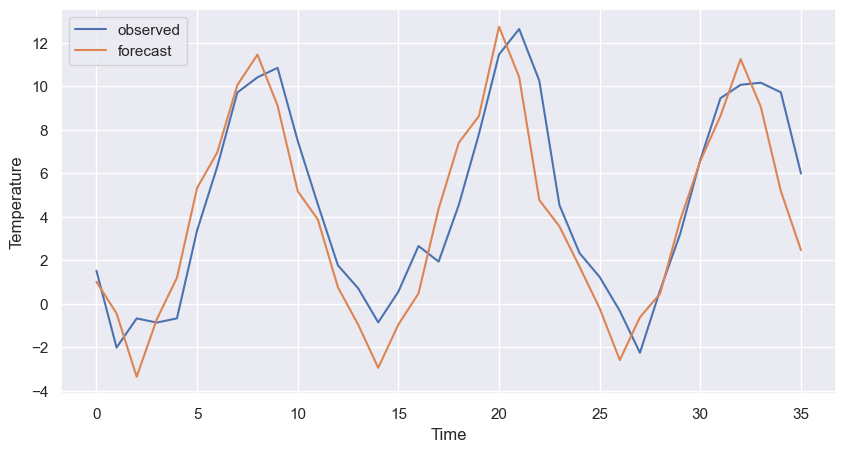

Mean squared error:3.9519256028094762
Root Mean Squared Error:1.9879450703702746
Mean absolute error:1.6113617995203111
Mean absolute percentage error:-8.516866894723533


In [159]:
# Multivariate model SARIMAX
# Fit the model
# Requirement: Endogenous variables must be stationary

#monthly_precip_mean_train_diff = monthly_precip_mean_train.diff(12).fillna(0)
#monthly_precip_mean_test_diff = monthly_precip_mean_test.diff(12).fillna(0)

model = SARIMAX(monthly_temp_mean_train, exog=monthly_precip_mean_train, order=(2, 0, 1), seasonal_order=(1, 0, 2, 12))
results = model.fit()

# Get the forecast
forecast = results.get_forecast(steps=36, exog=monthly_precip_mean_test)
forecast_mean = forecast.predicted_mean

# change index of forecast to be 0 to 3*12
forecast_mean.index = range(forecast_mean.size)

# Plot the forecast
plt.figure(figsize=(10,5))
plt.plot(monthly_temp_mean_test, label='observed')
plt.plot(forecast_mean, label='forecast')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# check mean squared error between forecsat and test data
print("Mean squared error:" + str(mean_squared_error(monthly_temp_mean_test, forecast_mean)))
print("Root Mean Squared Error:" + str(np.sqrt(mean_squared_error(monthly_temp_mean_test, forecast_mean))))

# match index of forecast to monthly_temp_mean_test
forecast_mean.index = monthly_temp_mean_test.index

print("Mean absolute error:" + str(np.mean(np.abs(monthly_temp_mean_test - forecast_mean[:3*12]))))
print("Mean absolute percentage error:" + str(np.mean(np.abs(monthly_temp_mean_test - forecast_mean)/monthly_temp_mean_test)*100))


/home/athena/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


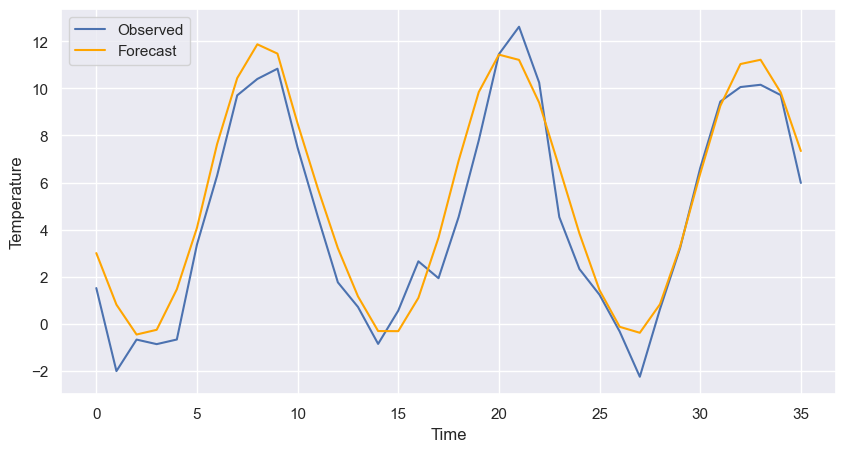

Mean Squared Error: 1.6356087250099878
Root Mean Squared Error: 1.2789091934183552
Mean Absolute Error: 1.050338786982647
Mean Absolute Percentage Error: 5.732478281951381


In [ ]:
# VAR Model fitting
# Scale the data
train_data = pd.concat([monthly_temp_mean_train, monthly_precip_mean_train, monthly_sun_mean_train], axis=1)
scaler = StandardScaler()
train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns, index=train_data.index)

# Apply differencing
train_data_diff = train_data_scaled.diff().dropna()

# Fit the VAR model on differenced data
model = VAR(train_data_diff)
results = model.fit(maxlags=12)

# Forecast in the differenced domain
forecast_diff = results.forecast(train_data_diff.values[-results.k_ar:], steps=36)

# Convert the forecast back to the original scale
# 1. Add the last row of scaled data (before differencing)
last_scaled_values = train_data_scaled.iloc[-1].values
forecast_scaled = np.cumsum(np.vstack([last_scaled_values, forecast_diff]), axis=0)[1:]

# 2. Inverse transform the forecast to the original scale
forecast_original = scaler.inverse_transform(forecast_scaled)

# Extract individual variables
var_forecast_temp = forecast_original[:, 0]
var_forecast_precip = forecast_original[:, 1]
var_forecast_sun = forecast_original[:, 2]

# Adjust test data index for plotting
monthly_temp_mean_test.index = range(0, 36)

# Plot temperature forecast
plt.figure(figsize=(10, 5))
plt.plot(monthly_temp_mean_test, label='Observed')
plt.plot(var_forecast_temp, label='Forecast', color='orange')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Evaluate the forecast
mse = mean_squared_error(monthly_temp_mean_test, var_forecast_temp)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(monthly_temp_mean_test - var_forecast_temp))
mape = np.mean(np.abs(monthly_temp_mean_test - var_forecast_temp) / monthly_temp_mean_test) * 100

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)



/home/athena/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/athena/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/athena/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/athena/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a sup

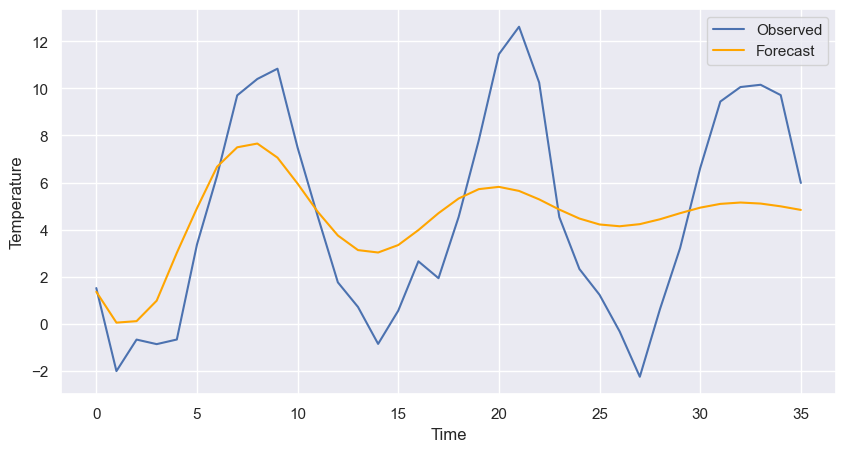

Mean Squared Error: 10.926275977755632
Root Mean Squared Error: 3.3054917906047856
Mean Absolute Error: 2.7815729282648176
Mean Absolute Percentage Error: -8.034653031877175


In [ ]:
# Combine the variables into a single DataFrame
train_data = pd.concat([monthly_temp_mean_train, monthly_precip_mean_train, monthly_sun_mean_train], axis=1)

# Reset the index to a simple integer index
train_data = train_data.reset_index(drop=True)

# Initialize the scaler and fit it on the training data
scaler = StandardScaler()
train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)

# Apply differencing
train_data_diff = train_data_scaled.diff().dropna()

# Fit VARMAX model on differenced data
model = VARMAX(train_data_diff, order=(4, 4))
results = model.fit(disp=False)

# Forecast in the differenced domain
forecast_diff = results.get_forecast(steps=36).predicted_mean

# Revert differencing
# Add the last known values before differencing
last_scaled_values = train_data_scaled.iloc[-1].values
forecast_scaled = np.cumsum(np.vstack([last_scaled_values, forecast_diff]), axis=0)[1:]

# Reverse the scaling to get the forecast in the original scale
forecast_original = pd.DataFrame(scaler.inverse_transform(forecast_scaled), 
                                  columns=train_data.columns)

# Extract individual variables from the forecast
varmax_forecast_temp = forecast_original['temperature_2m_mean (°C)']
varmax_forecast_precip = forecast_original['precipitation_sum (mm)']

# Plot the temperature forecast with confidence interval
plt.figure(figsize=(10, 5))
plt.plot(monthly_temp_mean_test.reset_index(drop=True), label='Observed')
plt.plot(varmax_forecast_temp, label='Forecast', color='orange')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Check mean squared error between forecast and test data
mse = mean_squared_error(monthly_temp_mean_test, varmax_forecast_temp)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(monthly_temp_mean_test - varmax_forecast_temp))
mape = np.mean(np.abs(monthly_temp_mean_test - varmax_forecast_temp) / monthly_temp_mean_test) * 100

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)

In [166]:
import itertools

# Define ranges for p and q
p_range = range(0, 5)
q_range = range(0, 5)
best_aic = float('inf')
best_order = None
best_model = None

for p, q in itertools.product(p_range, q_range):
    try:
        model = VARMAX(train_data_scaled, order=(p, q))
        results = model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = (p, q)
            best_model = results
    except Exception as e:
        continue

print(f"Best AIC: {best_aic} for order {best_order}")

/home/athena/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/athena/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/athena/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/athena/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/athena/.local/lib/pytho

Best AIC: 3650.3464536327547 for order (4, 4)


/home/athena/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


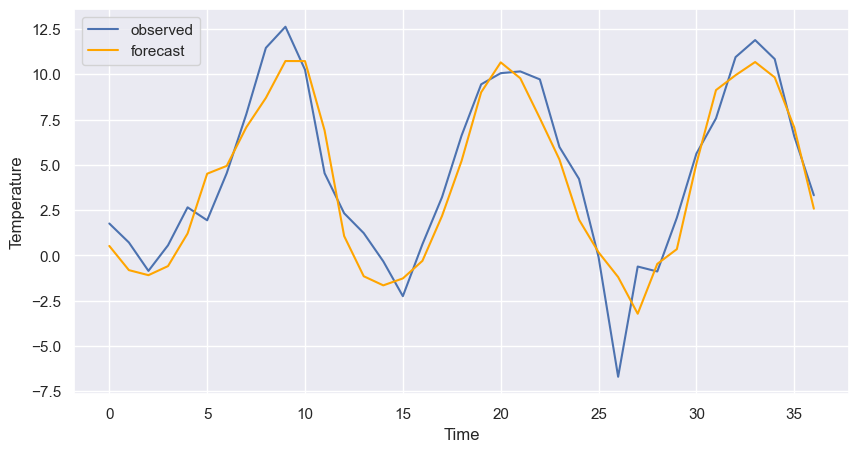

Mean squared error:2.804905457882636
Root Mean Squared Error:1.6747851975350856
Mean absolute error:1.3435713533998501
Mean absolute percentage error:6.5345660886819115


In [169]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

# NAR
def create_lagged_features(series, lag):
    X, y = [], []
    for i in range(lag, len(series)):
        X.append(series[i-lag:i])
        y.append(series[i])
    return np.array(X), np.array(y)

lag = 5  # Set the number of lagged observations to use for prediction
X, y = create_lagged_features(monthly_temp_mean, lag)

# Split Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.036, shuffle=False)

# Normalize the Data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Neural Network Model
model = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# Forecast
y_pred = model.predict(X_test_scaled)

# Plot the forecast
plt.figure(figsize=(10,5))
plt.plot(y_test, label='observed')
plt.plot(y_pred, label='forecast',color='orange')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()



print("Mean squared error:" + str(mean_squared_error(y_test, y_pred)))
print("Root Mean Squared Error:" + str(np.sqrt(mean_squared_error(y_test, y_pred))))

print("Mean absolute error:" + str(np.mean(np.abs(y_test - y_pred))))
print("Mean absolute percentage error:" + str(np.mean(np.abs(y_test - y_pred)/y_test)*100))


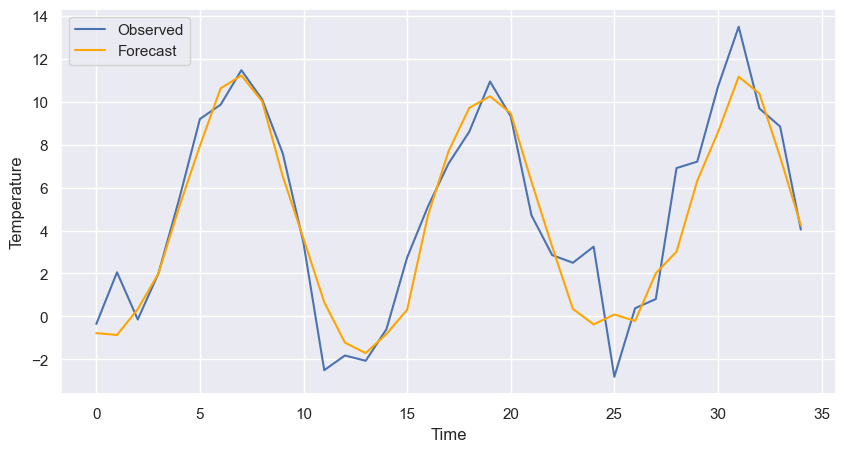

Mean Squared Error (MSE): 2.574628965027379
Root Mean Squared Error (RMSE): 1.6045650392013966
Mean Absolute Error (MAE): 1.1859629944118453
Mean Absolute Percentage Error (MAPE): 50.694036487389106


In [174]:
# Define function to create lagged features for NARX
def create_narx_features(endog, exog, lag):
    """
    Create lagged features for NARX model.

    Parameters:
    - endog: array-like, endogenous variable (target)
    - exog: DataFrame, exogenous variables
    - lag: int, number of lagged observations

    Returns:
    - X: array of lagged features (endogenous + exogenous)
    - y: target values
    """
    X, y = [], []
    for i in range(lag, len(endog)):
        # Include lagged endogenous variables
        lagged_endog = endog[i-lag:i]
        # Include corresponding lagged exogenous variables
        lagged_exog = exog.iloc[i-lag:i].values.flatten()
        X.append(np.concatenate((lagged_endog, lagged_exog)))
        y.append(endog[i])
    return np.array(X), np.array(y)

# Parameters
lag = 12  # Number of lagged observations

# Combine the variables into a single dataset
train_data = pd.concat([monthly_temp_mean_train, monthly_precip_mean_train, monthly_sun_mean_train], axis=1)
endog = monthly_temp_mean_train.values
exog = train_data[['precipitation_sum (mm)', 'sunshine_duration (s)']]

# Create lagged features and target for training
X, y = create_narx_features(endog, exog, lag)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.036, shuffle=False)

# Normalize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Neural Network Model
model = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# Forecast using the test data
y_pred = model.predict(X_test_scaled)

# Plot observed vs. forecasted temperature
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Observed')
plt.plot(y_pred, label='Forecast', color='orange')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error (MAPE):", np.mean(np.abs((y_test - y_pred) / y_test)) * 100)